In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import arviz as az
import corner

from util import fit_trapezoid_model_fixed, trapezoid_model, phasefold, plot_binned

%matplotlib inline
%load_ext autoreload
%autoreload 2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
gaia_info = pd.read_csv("data/gaia_dr3.csv", index_col=0).T
tic_info = pd.read_csv("data/tic_82.csv", index_col=0).T

In [48]:
# values from exofop
period = 1.7446997
epoch = 2459387.758989 - 2457000
depth = .000160
ror = np.sqrt(depth)
qtran = 0.927 / 24 / period
duration = qtran * period
zpt = 1

In [3]:
lc = pd.read_csv("data/lc.csv", index_col=0)
lc = lc[lc["quality"] == 0]

(0.9995, 1.0005)

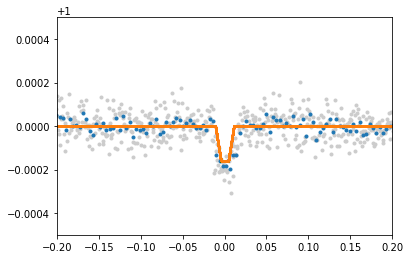

In [5]:
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(2/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(10/60/24)))
plt.scatter(
    phasefold(lc["time"], period, epoch),
    trapezoid_model(lc["time"], period, epoch, -depth, qtran, .3, 1),
    marker=".",
    s=1
)

plt.xlim(-.2, .2)
plt.ylim(0.9995, 1.0005)

In [162]:
# Assume there's a bound binary system causing eclipses
# where the main star is 10% as bright
# f_total = f_target + f_companion = 1
f = .1
def get_companion_ror(f, depth):
    # Assuming there's a companion system where the eclipses are actually taking place
    # Return the radius ratio associated with that eclipse depth after removing flux
    # from the original star
    target_flux = 1 / (1 + f)
    companion_flux = 1 - target_flux
    depth_companion = 1 - (1 - depth - target_flux) / (1 - target_flux)
    return np.sqrt(depth_companion)

companion_ror = get_companion_ror(f, depth)
print(companion_ror)

def get_qingress(duration, ror):
    tflat = duration * np.sqrt((1 - ror)**2/(1 + ror)**2)
    return (1 - tflat / duration) / 2

0.041952353926812486


<ipython-input-162-ae1b3f7aada9>:11: RuntimeWarning: divide by zero encountered in true_divide
  depth_companion = 1 - (1 - depth - target_flux) / (1 - target_flux)
<ipython-input-162-ae1b3f7aada9>:18: RuntimeWarning: invalid value encountered in true_divide
  tflat = duration * np.sqrt((1 - ror)**2/(1 + ror)**2)


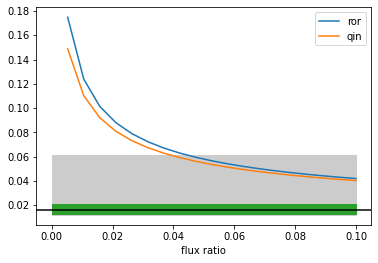

In [193]:
fs = np.linspace(0, 0.1, 20)
rors = get_companion_ror(fs, depth)
qins = get_qingress(duration, rors)
plt.plot(fs, rors, label="ror")
plt.plot(fs, qins, label="qin")

# qin 1 [0.016 0.013 0.021]
# qin 2 [0.016 0.012 0.061]
# qin 3 [0.016 0.011 0.181]
plt.axhline(0.016, c="k")

plt.fill_between(fs, 0.012, 0.061, color="0.8")
plt.fill_between(fs, 0.013, 0.021, color="tab:green")

plt.xlabel("flux ratio")
plt.legend()

In [ ]:
ror = 

In [152]:
# Trapezoid model

In [161]:
def get_trapezoid_model_from_ror(time, period, epoch, companion_ror, qtran, f):
    target_flux = 1 / (1 + f)
    companion_flux = 1 - target_flux
    companion_depth = -companion_ror**2
    duration = period * qtran
    tflat = duration * np.sqrt((1 - companion_ror)**2/(1 + companion_ror)**2)
    qin = (1 - tflat / duration) / 2
    return (
        trapezoid_model(lc["time"], period, epoch, companion_depth, qtran, qin, 1) * companion_flux
        + target_flux
    )

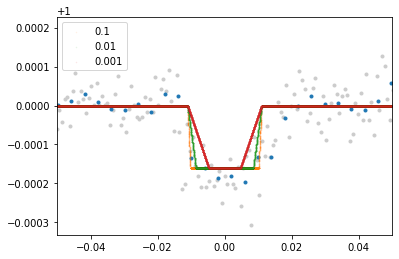

In [182]:
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(2/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(10/60/24)))

for f in [0.1, 0.01, 0.001]:
    companion_ror = get_companion_ror(f, depth)

    plot_binned(
        lc["time"], 
        get_trapezoid_model_from_ror(lc["time"], period, epoch, companion_ror, qtran, f),
        period,
        epoch,
        label=f,
        alpha=0.1,
        s=1
    )

plt.xlim(-.05, .05)
plt.legend()

In [42]:
# Exoplanet fit

In [166]:
solns = {}

In [169]:
f = 0.1
companion_ror = get_companion_ror(f, depth)
target_flux = 1 / (1 + f)
companion_flux = 1 - target_flux

phase = phasefold(lc["time"], period, epoch)
in_transit_mask = np.abs(phase) < 2 * duration / period

with pm.Model() as model:
    t0 = pm.Uniform("t0", lower=epoch - .1 * period, upper = epoch + .1 * period)
    per = pm.Uniform("per", lower=0.9*period, upper=1.1*period)  
    dur = pm.Uniform("dur", lower=.9*duration, upper=1.1*duration)
    b = pm.Uniform("b", lower=-(companion_ror + 1), upper=(companion_ror + 1))
    
    r_star = pm.Uniform("r_star", lower=0, upper=2)
    
    orbit = xo.orbits.SimpleTransitOrbit(
        per,
        dur,
        t0=t0,
        r_star=r_star,
        ror=companion_ror,
        b=b,
    )
    u = xo.distributions.QuadLimbDark("u")
    lcs = pm.Deterministic(
        "lcs",
        xo.LimbDarkLightCurve(u).get_light_curve(
            orbit=orbit,
            r=companion_ror*r_star,
            t=lc["time"][in_transit_mask],
            use_in_transit=False,
            light_delay=False,
        )
    )
    mean = pm.Normal("mean", mu=1.0, sd=0.5)
    full_lc = tt.sum(lcs, axis=-1)*companion_flux + target_flux + mean
    pm.Deterministic("full_lc", full_lc)
    
    # Observation model
    pm.Normal(
        "obs", 
        mu=full_lc, 
        sd=lc["flux_err"][in_transit_mask], 
        observed=lc["flux"][in_transit_mask], 
        shape=len(lc[in_transit_mask])
    )
    
    map_soln = pmx.optimize(start=model.test_point, vars=[mean])
    map_soln = pmx.optimize(start=map_soln)
    solns[f] = map_soln

optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -26616826776.595913 -> 266993.5042927507
optimizing logp for variables: [mean, u, r_star, b, dur, per, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 266993.5042927507 -> 267006.0697165775


(-0.05, 0.05)

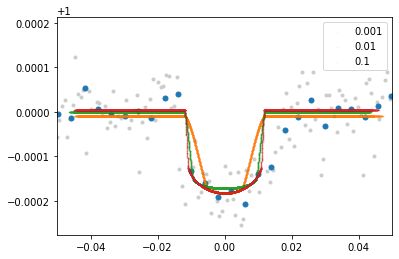

In [181]:
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(2/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(10/60/24)), s=100)

for f, soln in solns.items():
    plot_binned(lc["time"][in_transit_mask], soln["full_lc"], soln["per"], soln["t0"], s=1, label=f, alpha=0.1)
    
plt.legend()
plt.xlim(-.05, .05)

In [157]:
def get_rho(period, duration, depth, transit_shape):
    # following 1.14 from aude thesis
    G = 2942 # Rsun^3 / Msun / day^2
    return 32 * period * depth**0.75 / G / 3.14159 / duration**3 / (1 - transit_shape**2)**1.5

In [10]:
###### ALTERNATE ARGUMENT

In [4]:
distance = 1 / (float(gaia_info["parallax"][0]) / 1000) # parallax comes in mas
print("Distance:", distance, "pc")

Distance: 15.215602808581622 pc


In [5]:
# Gemini from 2020-06-11 (soar image is less sensitive)
# some ref points.
# dmag 4.8 = .1 arcsec
# dmag 5 = .2 arcsec
# dmag 6 = 0.4 arcsec
dmag = 5
angular_separation = 0.2 # arcsec

parallax = float(gaia_info["parallax"][0]) # in mas
distance = distance = 1 / (parallax / 1000) # in pc
separation = (
    angular_separation / 3600 * 2 * 3.14159 / 360 # to rad
    * distance * 206265 # to au
)
print(separation, "au")

3.043120849826581 au


In [6]:
target_mass = float(tic_info["mass"][0])
period = (separation**3 / target_mass)**(1/2)
print(period, "yr")

8.179279110536763 yr


In [220]:
float(tic_info["lum"][0])

0.023779847

In [11]:
dmag = 5
target_lum = float(tic_info["lum"][0])
print(target_lum, "L_sun")
lum = 10**(dmag / -2.5) * target_lum
print(lum, "L_sun")
mass = lum**(1/3.5)
print(mass, "M_sun")

0.023779847 L_sun
0.00023779847 L_sun
0.09217882308508295 M_sun


In [8]:
target_lum

0.023779847

In [214]:
semiamplitude = (
    28.4329 
    * mass * 1047.57 # to m_j
    * (mass + target_mass)**(-1/2) * separation**(-1/2)
)
print(semiamplitude) # in m/s

2196.5481201908374


In [215]:
gdr3_baseline = 34 # months

quarter_period = period / 4
# we expect RV to change by semiamplitude in quarter_period
expected_rv_delta = (
    gdr3_baseline / 12
    / quarter_period
    * semiamplitude
)
print(expected_rv_delta)

print(gaia_info["radial_velocity"][0], gaia_info["radial_velocity_error"][0], "km/s")

3043.57042868975
26.240705490112305 0.17365583777427673 km/s


2987.4816951235525 1020


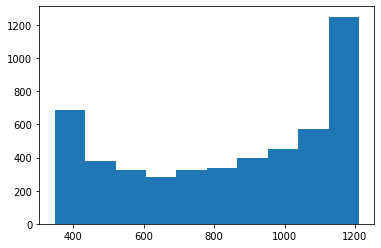

In [216]:
# Random sampling approach
period_days = period * 365.25
baseline_days = gdr3_baseline * 30
print(period_days, baseline_days)
def rv(t):
    return semiamplitude * np.sin(t * 2 * 3.14 / period_days)
t = np.linspace(0, 2 * period_days, 2 * int(period_days))
stds = []
for _ in range(5000):
    i = np.random.randint(int(period_days))
    stds.append(np.std(rv(t[i:i + baseline_days])))
stds = np.array(stds)

plt.hist(stds)
plt.show()